# MCMC Demo
### Run Script to run 15000 MCMC steps in an example system

Imports

# MCMC Demo
### Run Script to run 15000 MCMC steps in an example system

In [ ]:
import os
import numpy as np
import subprocess
import json
import csv
from datetime import datetime
from demo_utils import get_project_root
from IPython.display import Image, display
from demo_utils import set_icl_color_cycle
set_icl_color_cycle()


Define run_simulation function

In [2]:
def run_simulation(params, job_name, results_csv, log_dir, experiment_dir):
    """
    Run the simulation and append results.
    """
    specific_output_path = os.path.join(
        experiment_dir,  # Ensure it's within experiment_dir
        f"rho_{params['initial_rho']:.2f}_T_{params['temperature']:.3f}_AR_{params['aspect_ratio']:.3f}"
    )
    os.makedirs(specific_output_path, exist_ok=True)
    print(f"Created/Verified output directory: {specific_output_path}")

    # Define log file paths
    stdout_log = os.path.join(log_dir, f"{job_name}.out")
    stderr_log = os.path.join(log_dir, f"{job_name}.err")

    base_dir = get_project_root()
    if base_dir is None:
        print("Error: Could not find project root directory.")
        return

    # Path to main.py in project root
    main_script = os.path.join(base_dir, "MCMC", "main.py")

    # Construct the main simulation command
    simulation_cmd = [
        'python', main_script,
        '--temperature', str(params['temperature']),
        '--num_particles', str(params['num_particles']),
        '--initial_rho', str(params['initial_rho']),
        '--aspect_ratio', str(params['aspect_ratio']),
        '--equilibration_steps', str(params['equilibration_steps']),
        '--production_steps', str(params['production_steps']),
        '--sampling_frequency', str(params['sampling_frequency']),
        '--adjusting_frequency', str(params['checkpoint_frequency']),
        '--output_path', specific_output_path,
        '--experiment_id', params['experiment_id'],
        # **New Arguments for External Potential**
        '--num_wells', str(params['num_wells']),
        '--V0_list', *map(str, params['V0_list']),
        '--k', str(params['k']),
        '--r0', str(params['r0']),
        '--initialisation_type', params['initialisation_type'],
        '--seed', str(params['seed']),
        '--initial_max_displacement', str(params['initial_max_displacement'])
    ]

    # Include flags based on parameters
    if params.get('visualise', False):
        simulation_cmd.append('--visualise')
    if params.get('checking', False):
        simulation_cmd.append('--checking')
    if params.get('time_calc', False):
        simulation_cmd.append('--time_calc')

    # Path to append_results.py in scripts directory
    append_script = os.path.join(base_dir, "MCMC", "scripts", "append_results.py")

    # Construct the append results command
    append_cmd = [
        'python', append_script,
        results_csv,
        specific_output_path,
        str(params['temperature']),
        str(params['equilibration_steps'])
    ]

    # Open log files
    with open(stdout_log, 'w') as out, open(stderr_log, 'w') as err:
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Starting job {job_name}")
        # Run the simulation
        sim_process = subprocess.run(simulation_cmd, stdout=out, stderr=err, cwd=base_dir)
        if sim_process.returncode == 0:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Simulation {job_name} completed successfully.")
        else:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Simulation {job_name} failed. Check logs for details.")

        # Run the append results
        append_process = subprocess.run(append_cmd, stdout=out, stderr=err, cwd=base_dir)
        if append_process.returncode == 0:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Results appended for job {job_name}.")
        else:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Appending results for job {job_name} failed. Check logs for details.")


Run demo experiment with the params varibales - edit these as desired, an example with three particles and box length 10 is given

In [ ]:
base_dir = get_project_root()
if base_dir is None:
    print("Error: Could not find project root directory.")
else:
    params = {
        "num_particles": 10,
        "initial_rho": 0.01,
        "equilibration_steps": 5000,
        "production_steps": 10000,
        "sampling_frequency": 150,
        "checkpoint_frequency": 5000,  # Typically (equil + prod)/5 or user-chosen
        "output_path": os.path.join(base_dir,"demos", "data"),
        "experiment_id": "test_mcmc",
        "temperature": 1.00,       # Number of temperature intervals
        "aspect_ratio": 1.0,
        "visualise": True,            # Set to True if you want visualization for individual runs
        "checking": True,             # Enable logging of density and box volume
        "num_wells": 2,                # Number of external potential wells (0, 1, or 2)
        "V0_list": [-10.0,-10.00],                    # Depth of the potential wells
        "k": 15,                       # Width parameter for the Gaussian wells
        "r0": 3.0,                     # radius of bottom of well
        "initialisation_type": "right_half",  # Type of initialisation for particles: 'all', 'left_half', 'right_half'
        "seed": 42,
        "initial_max_displacement": 0.65  # Initial maximum displacement for Monte Carlo moves
    }
    # Create output directories\n",
    output_path = os.path.join(base_dir, "demos", "data")
    experiment_dir = os.path.join(output_path, params['experiment_id'])
    os.makedirs(experiment_dir, exist_ok=True)
    print(f"Created/Verified experiment directory: {experiment_dir}")
    
    # Create log directory
    log_dir = os.path.join(experiment_dir, 'logs')
    os.makedirs(log_dir, exist_ok=True)
    print(f"Created/Verified log directory: {log_dir}")
    
    # Create results CSV
    results_csv = os.path.join(experiment_dir, "results.csv")
    if not os.path.exists(results_csv):
        with open(results_csv, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Temperature", "Aspect_Ratio", "Density", "Average_Pressure"])
        print(f"Initialized results CSV at {results_csv}")
    
    # Save parameters to JSON
    params_file = os.path.join(experiment_dir, 'parameters.json')
    with open(params_file, 'w') as f:
        json.dump(params, f, indent=4)
    print(f"Saved experiment parameters to {params_file}")
    # Define job name,
    job_name = f"{params['experiment_id']}_rho{params['initial_rho']:.2f}_T{params['temperature']:.3f}_AR{params['aspect_ratio']:.3f}"

run_simulation(params, job_name, results_csv, log_dir, experiment_dir)

## Example plots outputed shown below

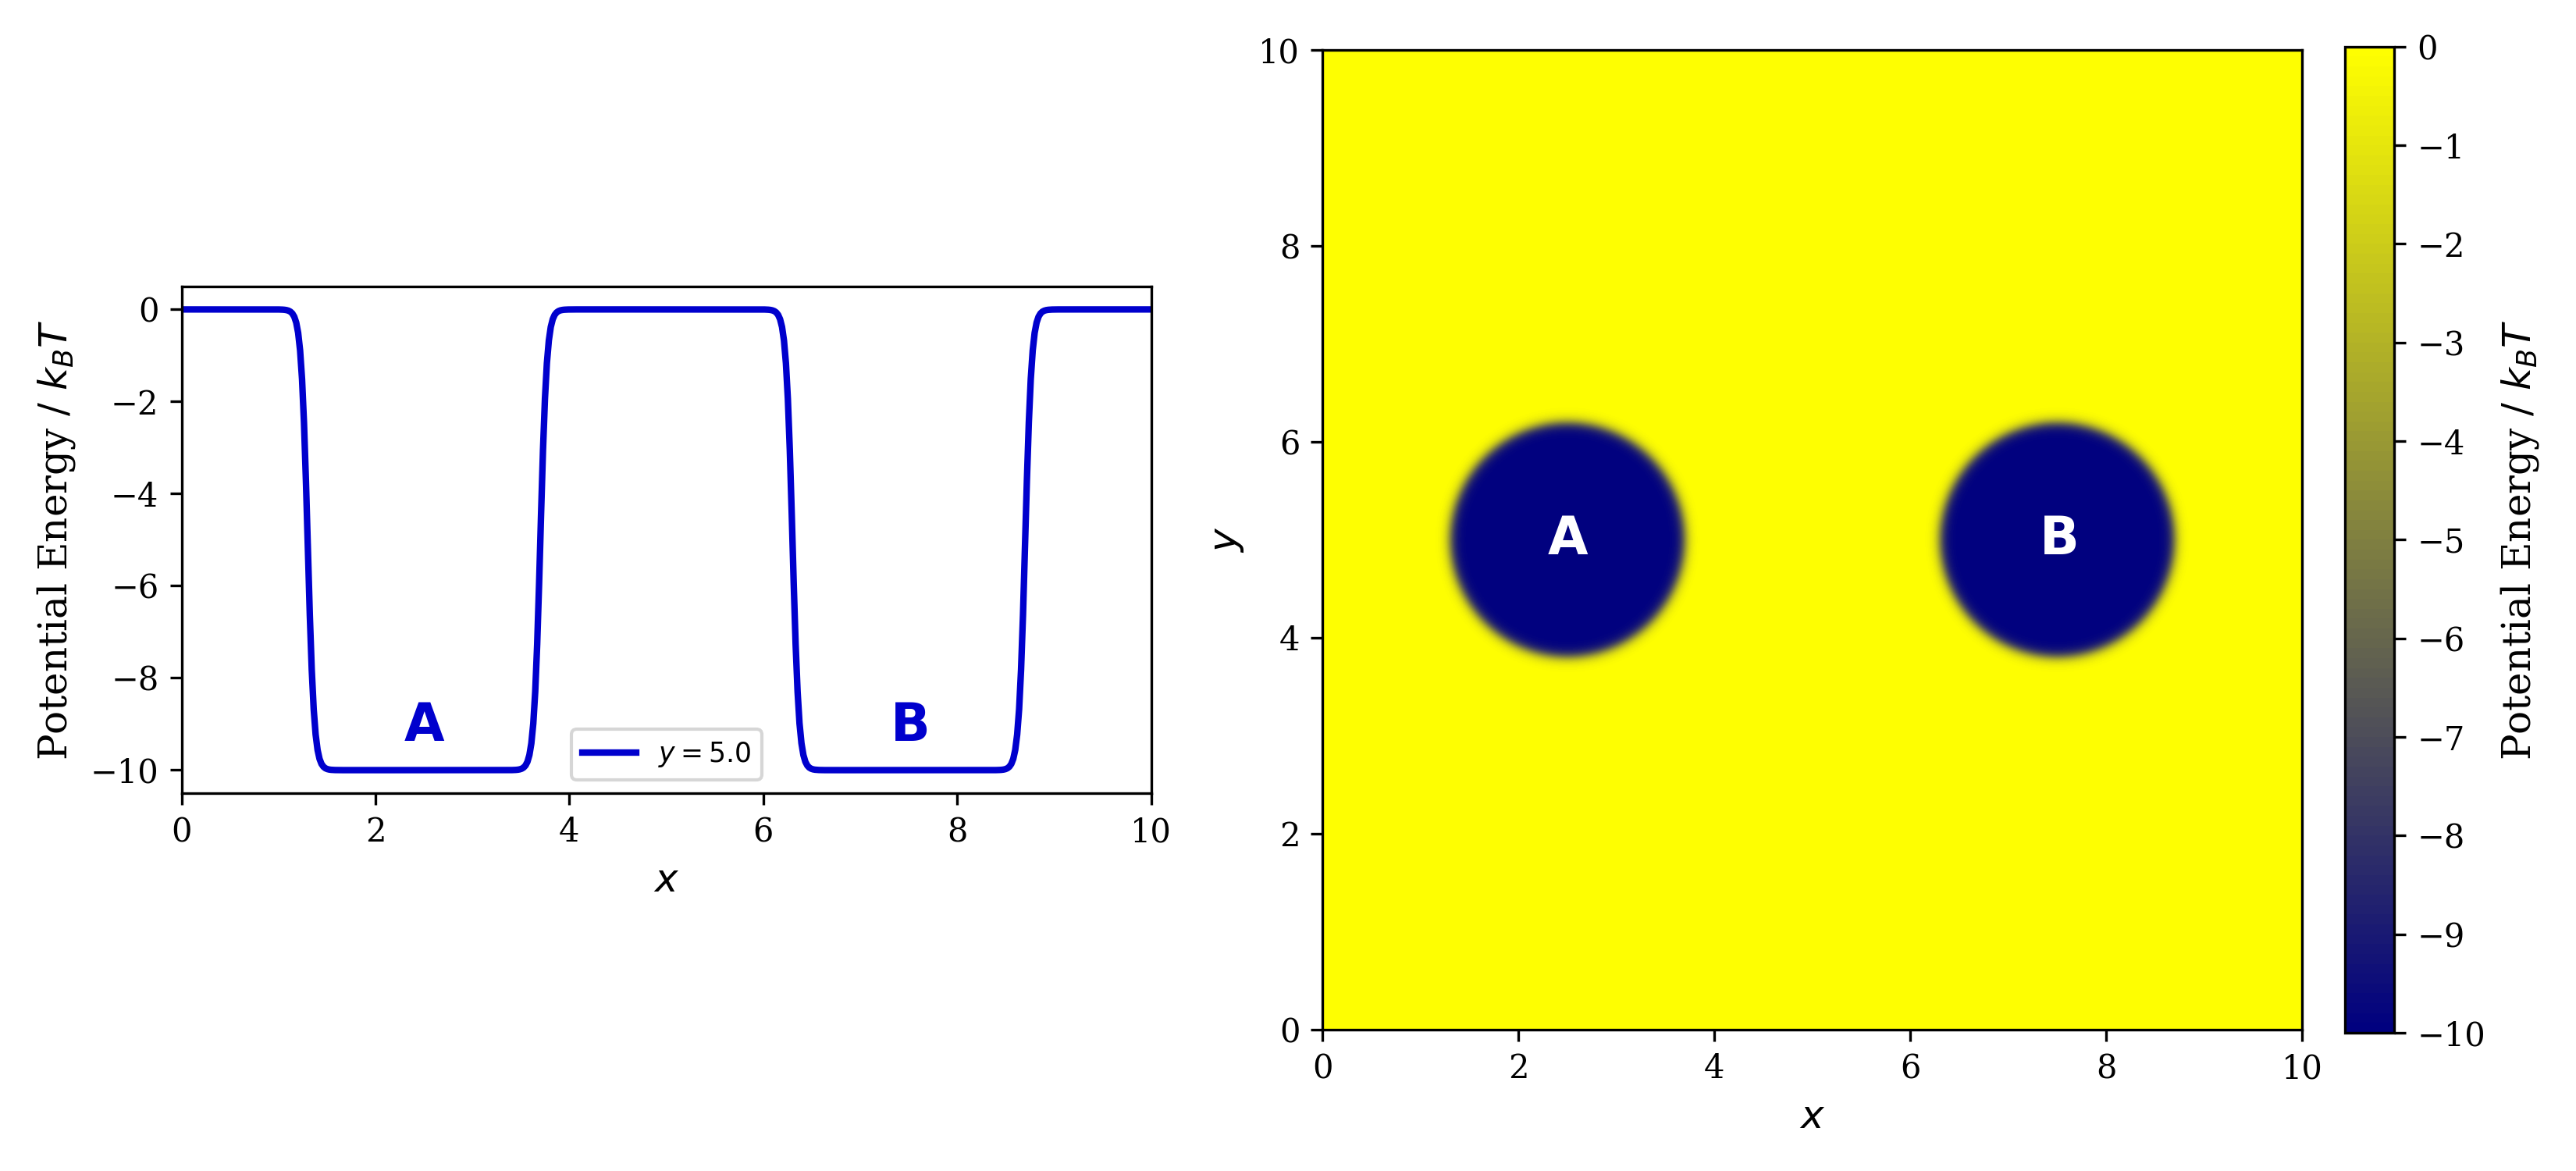

In [18]:
# Example double well potential set-up

display(Image(filename='/Users/inesalmansa/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Thesis/flow_state/demos/examples/double_well_concave_potential_combined.png'))


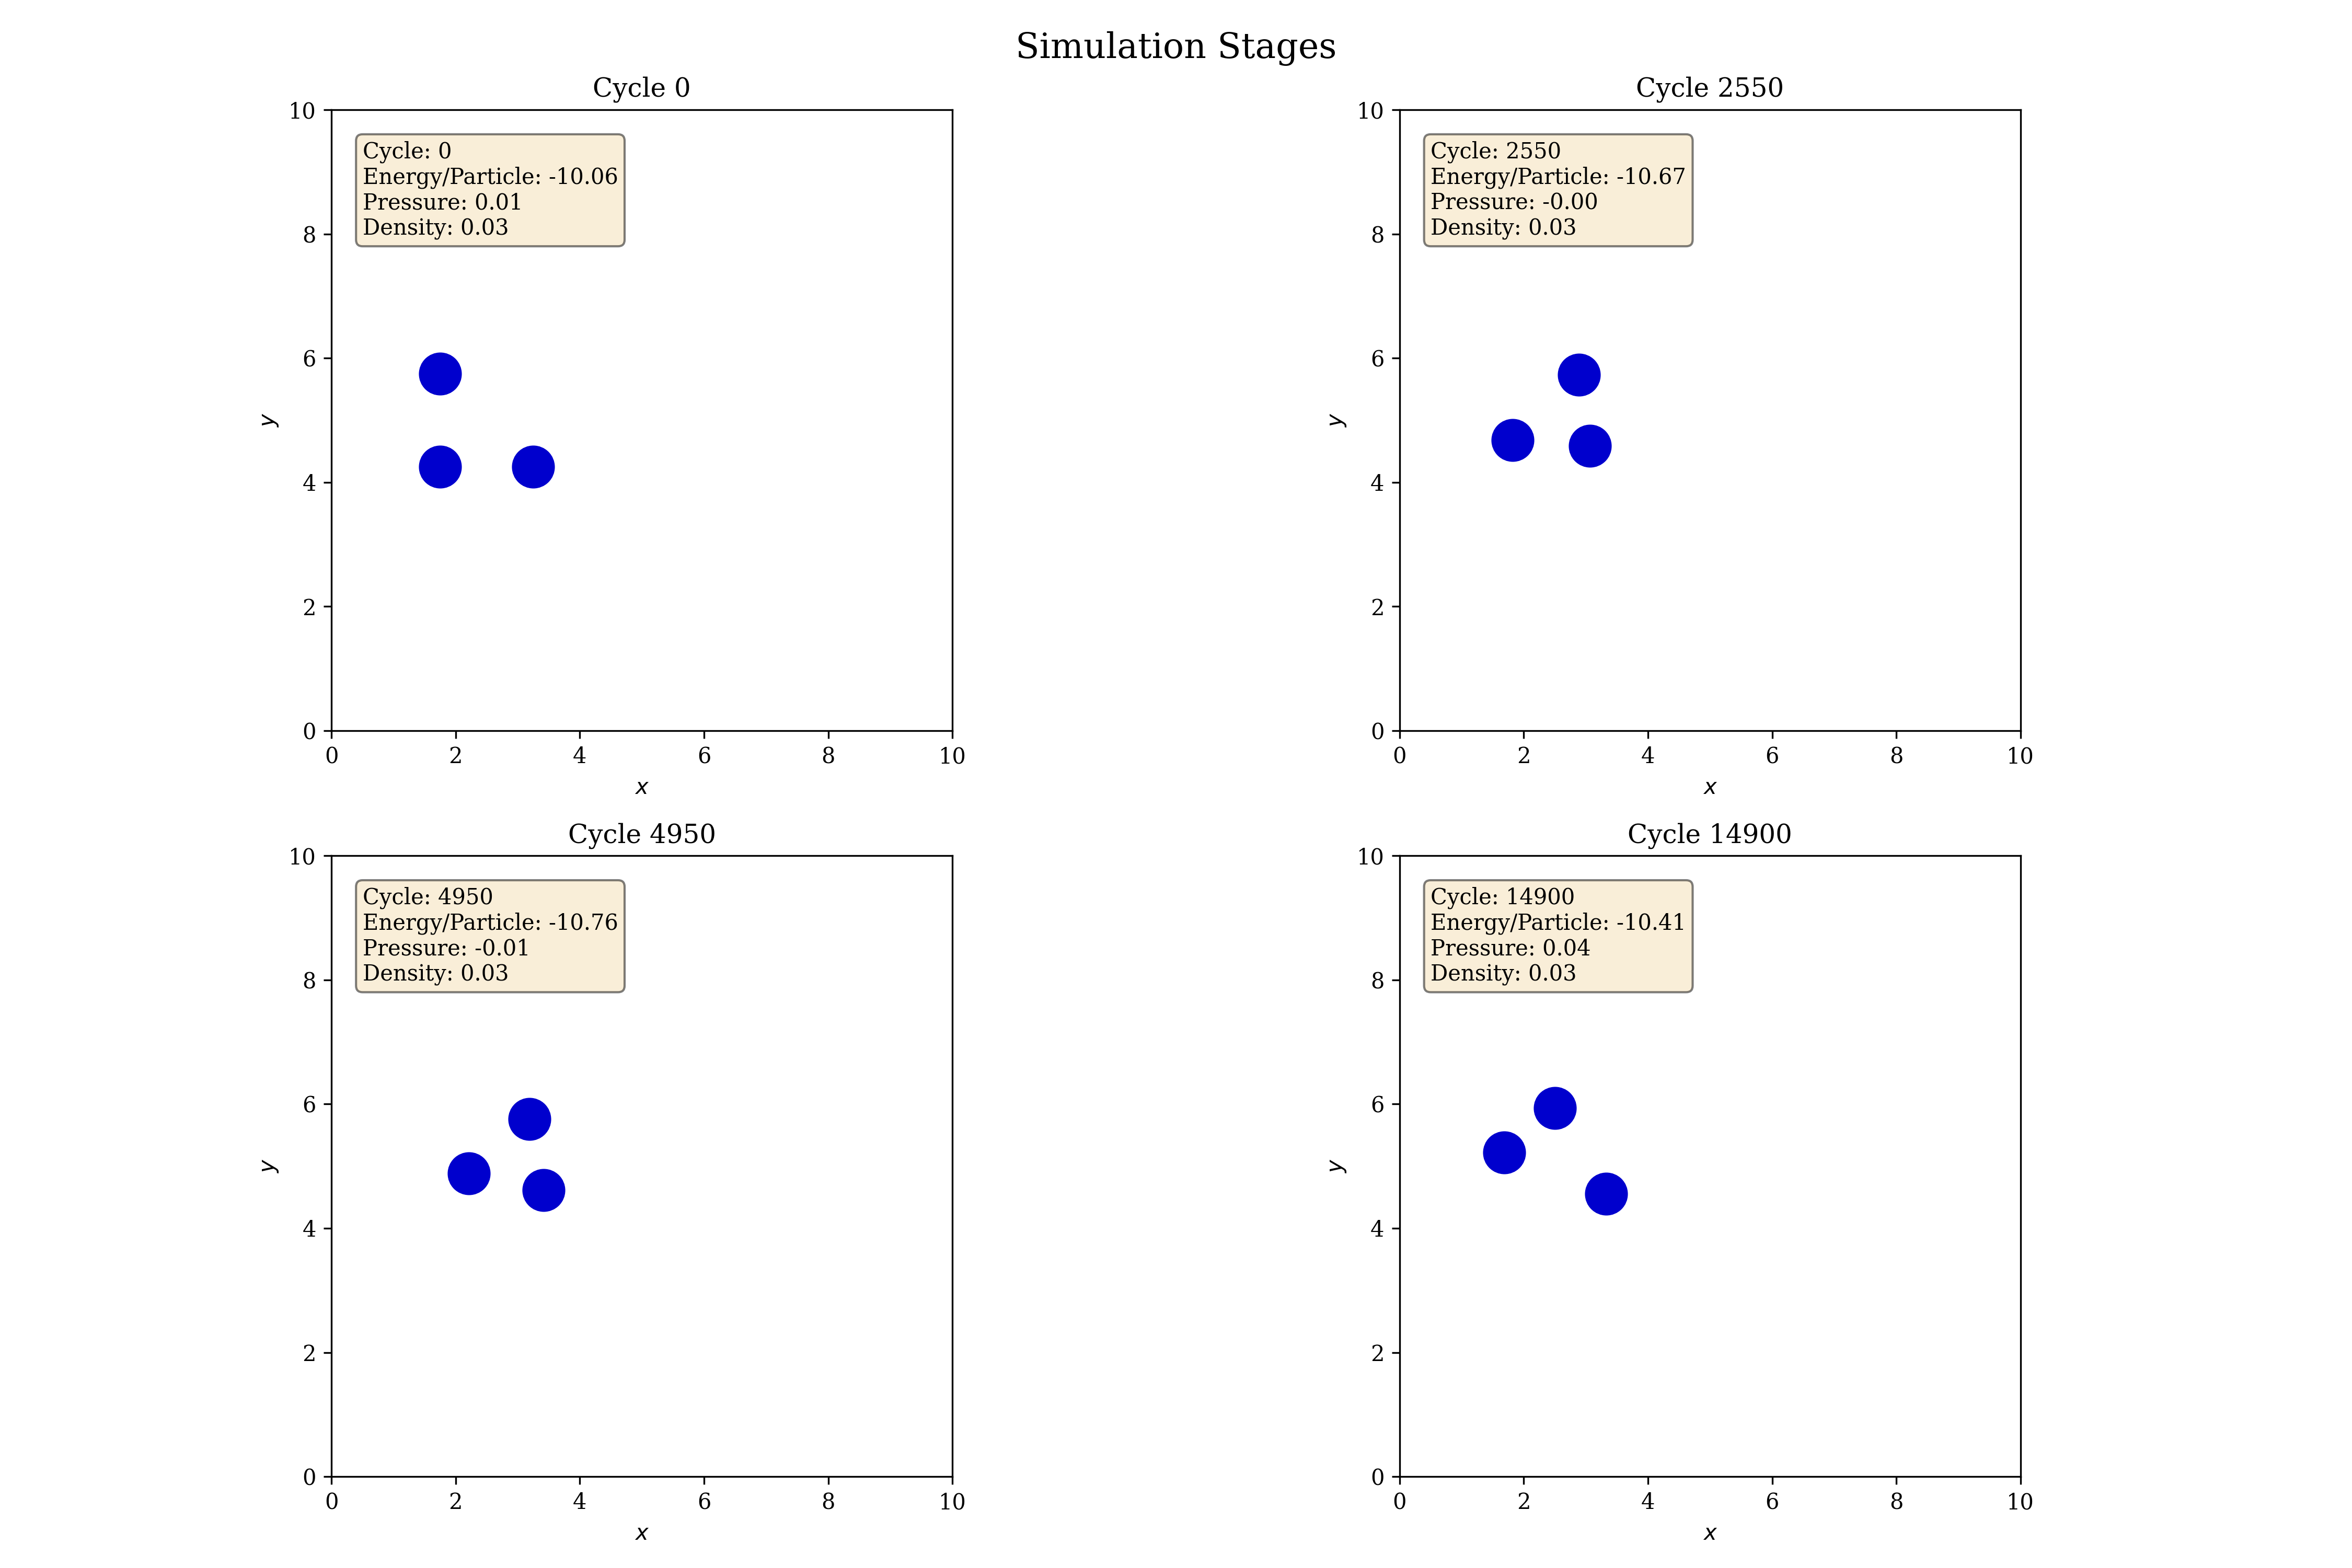

In [19]:
# Example visualisation of snapshots from a MCMC run
display(Image(filename='/Users/inesalmansa/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Thesis/flow_state/demos/examples/simulation_visualisation.png'))
